In [ ]:
!pip install imblearn

In [ ]:
!pip install xgboost

In [ ]:
!pip install category_encoders


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 715.7 kB/s eta 0:00:00


# 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from datetime import datetime
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImblearnPipeline
import category_encoders as ce
from sklearn.pipeline import Pipeline


# 2. Data Preprocessing

Step 1: Collect Data

In [ ]:
# Load the datasets
train_df = pd.read_csv("fraudTrain3.csv")
test_df = pd.read_csv("fraudTest3.csv")

# Display the first few rows of the datasets
print("Training Data:\n", train_df.head())
print("Testing Data:\n", test_df.head())

Training Data:
    Unnamed: 0 trans_date_trans_time        cc_num  \
0           0   2019-01-01 00:00:18  2.703186e+15   
1           1   2019-01-01 00:00:44  6.304233e+11   
2           2   2019-01-01 00:00:51  3.885949e+13   
3           3   2019-01-01 00:01:16  3.534094e+15   
4           4   2019-01-01 00:03:06  3.755342e+14   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suite 393  ...  48.8878 -1

In [ ]:
# Check the total number of instances
num_instances = len(train_df)
print(f'Total number of instances: {num_instances}')

# Verify the presence of 'is_fraud' column
if 'is_fraud' not in train_df.columns:
    raise KeyError("'is_fraud' column not found in the dataset")

# Check the total number of fraud cases
num_fraud_cases = train_df['is_fraud'].sum()
print(f'Total number of fraud cases: {num_fraud_cases}')

Total number of instances: 685915
Total number of fraud cases: 4090.0


Step 2: Clean Data: Address any missing or corrupt data. Drop rows with missing values



In [ ]:
# Check for missing values
print("\nMissing values in training data:\n", train_df.isnull().sum())
print("Missing values in testing data:\n", test_df.isnull().sum())


Missing values in training data:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   1
merchant                 1
category                 1
amt                      1
first                    1
last                     1
gender                   1
street                   1
city                     1
state                    1
zip                      1
lat                      1
long                     1
city_pop                 1
job                      1
dob                      1
trans_num                1
unix_time                1
merch_lat                1
merch_long               1
is_fraud                 1
dtype: int64
Missing values in testing data:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
s

In [ ]:
# Dropping rows with missing values (if any)
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [ ]:
# Check for missing values again
print("\nMissing values in training data:\n", train_df.isnull().sum())
print("Missing values in testing data:\n", test_df.isnull().sum())


Missing values in training data:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
Missing values in testing data:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
s

Step 3: Feature Engineering: Create new feature "hour of the day" to enhance patterns analysis

In [ ]:
# Convert 'unix_time' to 'transaction_time' and extract 'hour_of_day'
train_df['transaction_time'] = train_df['unix_time'].apply(lambda x: datetime.utcfromtimestamp(x))
train_df.drop(columns=['unix_time'], inplace=True)
train_df['hour_of_day'] = train_df['transaction_time'].dt.hour

In [ ]:
# Check
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 685914 entries, 0 to 685913
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             685914 non-null  int64         
 1   trans_date_trans_time  685914 non-null  object        
 2   cc_num                 685914 non-null  float64       
 3   merchant               685914 non-null  object        
 4   category               685914 non-null  object        
 5   amt                    685914 non-null  float64       
 6   first                  685914 non-null  object        
 7   last                   685914 non-null  object        
 8   gender                 685914 non-null  object        
 9   street                 685914 non-null  object        
 10  city                   685914 non-null  object        
 11  state                  685914 non-null  object        
 12  zip                    685914 non-null  float64  

# 3. Exploratory Data Analysis (EDA)

Spending Category VS Fraud


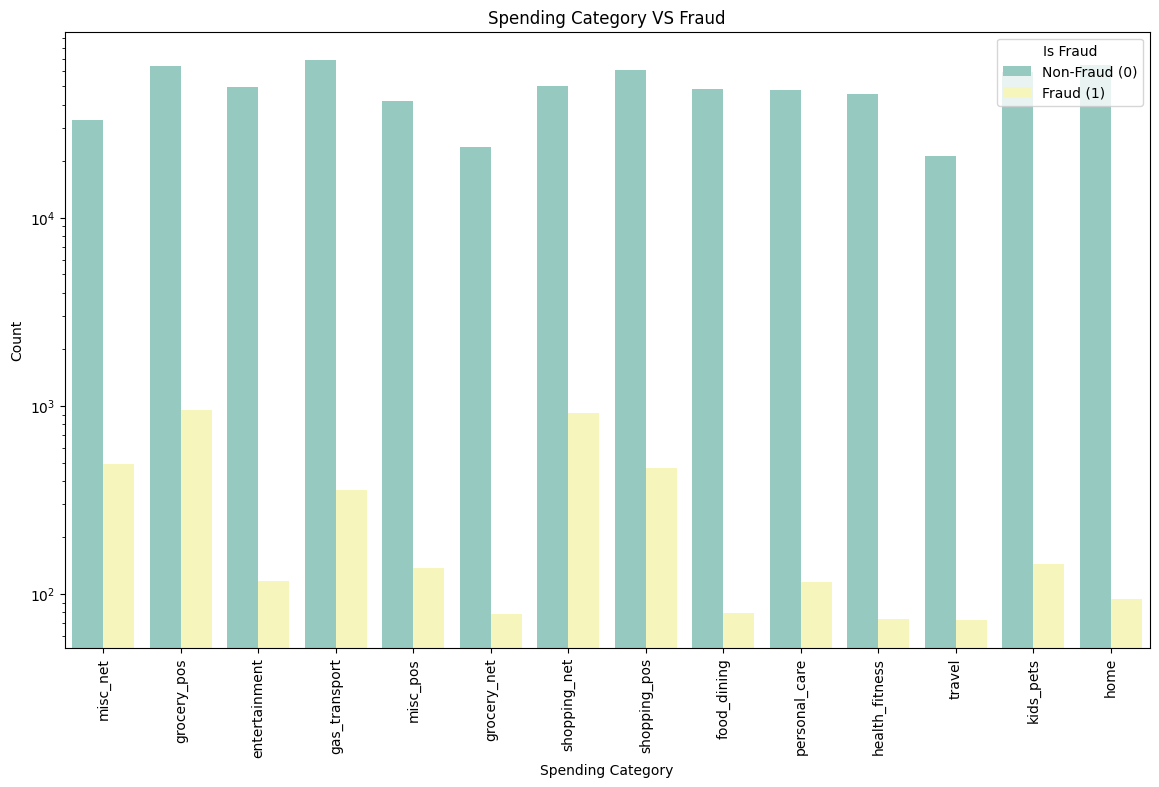

In [ ]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=train_df, x='category', hue='is_fraud', palette='Set3')
plt.title('Spending Category VS Fraud')
plt.xlabel('Spending Category')
plt.ylabel('Count')
plt.yscale('log')
plt.xticks(rotation=90)
plt.legend(title='Is Fraud', loc='upper right', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

Gender VS Fraud

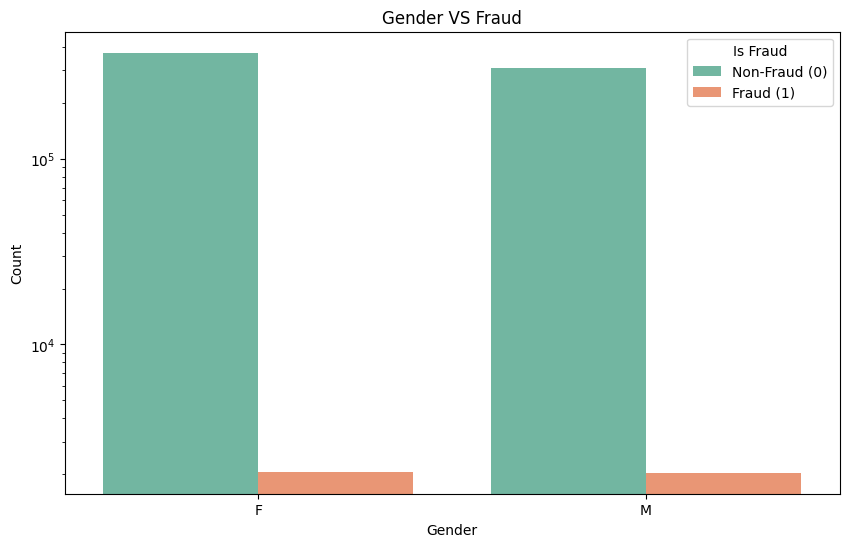

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train_df, x='gender', hue='is_fraud', palette='Set2')
plt.title('Gender VS Fraud')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.yscale('log')
plt.legend(title='Is Fraud', loc='upper right', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()


State VS Fraud

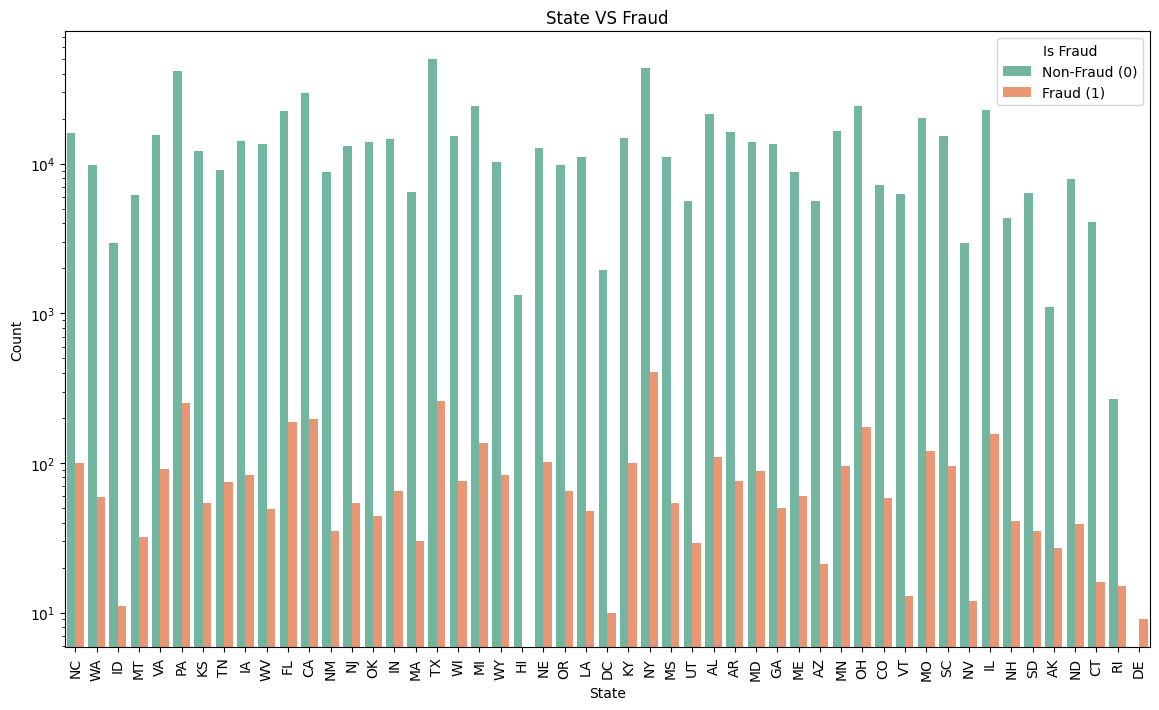

In [ ]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=train_df, x='state', hue='is_fraud', palette='Set2')
plt.title('State VS Fraud')
plt.xlabel('State')
plt.ylabel('Count')
plt.yscale('log')
plt.xticks(rotation=90)
plt.legend(title='Is Fraud', loc='upper right', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

Cyclicality of Credit Card Fraud

<ipython-input-15-a828a380e0f7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_by_hour, x='hour_of_day', y='is_fraud', palette='Set2')


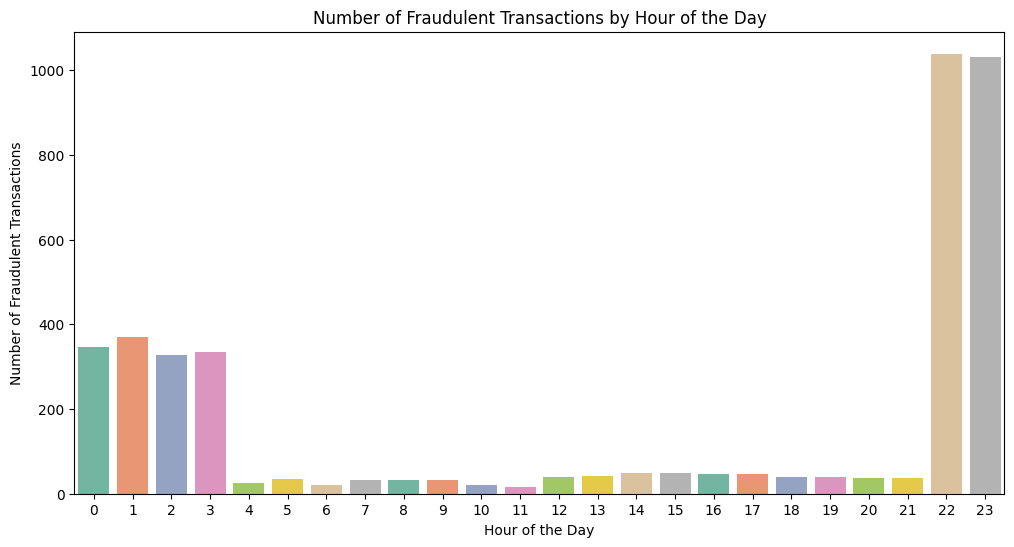

In [ ]:
fraud_by_hour = train_df.groupby('hour_of_day')['is_fraud'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_hour, x='hour_of_day', y='is_fraud', palette='Set2')
plt.title('Number of Fraudulent Transactions by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

# 4. Train the model

In [ ]:
# New Feature Based on EDA - Flag High Risk Hours
train_df['high_risk_hour'] = train_df['hour_of_day'].apply(lambda x: 1 if x > 22 or x < 5 else 0)

In [ ]:
# Separate features and target variable
X = train_df.drop(columns=['is_fraud', 'transaction_time'])
y = train_df['is_fraud']

In [ ]:
# Define categorical and numerical features
categorical_features = ['category', 'state']  # 'state' and 'category' found impactful in EDA
numerical_features = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'high_risk_hour'] # 'high_risk_hour' found impactful in EDA

In [ ]:
# Pipeline for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [ ]:
# Pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [ ]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
model = ImblearnPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=41))
])

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amt', 'lat', 'long',
                                                   'merch_lat', 'merch_long',
                                                   'high_risk_hour']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 's...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=41, ...))])

# 5. Evaluate the model

Initial Model Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    136365
         1.0       0.35      0.86      0.49       818

    accuracy                           0.99    137183
   macro avg       0.67      0.92      0.74    137183
weighted avg       1.00      0.99      0.99    137183



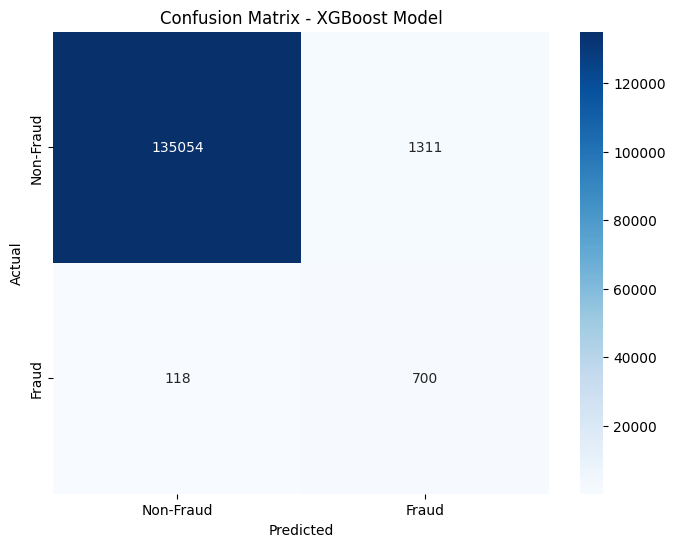

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
print("Initial Model Classification Report:\n", classification_report(y_test, y_pred))

# Visualize the confusion matrix
conf_matrix_initial = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_initial, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - XGBoost Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 6. Model Optimization and Tuning

In [ ]:

# Hyperparameter grid for XGBoost
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}


In [ ]:
# Setup RandomizedSearchCV with early stopping
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   n_iter=50,  # Increase number of iterations
                                   scoring='accuracy',
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

In [ ]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best model after Randomized Search
best_model = random_search.best_estimator_

# Predict using the best model
y_pred_tuned = best_model.predict(X_test)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#7. Re-evaluate the Tuned Model

Tuned Model Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    136365
         1.0       0.49      0.81      0.61       818

    accuracy                           0.99    137183
   macro avg       0.75      0.90      0.80    137183
weighted avg       1.00      0.99      0.99    137183



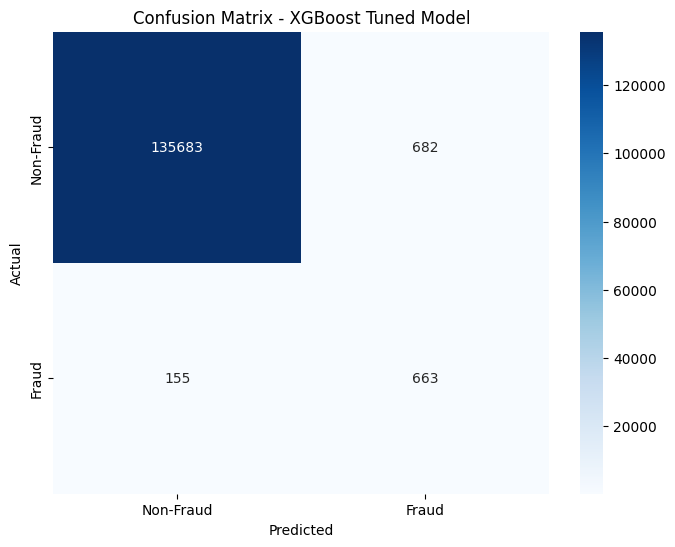

In [ ]:
# Evaluation results
print("Tuned Model Classification Report:\n", classification_report(y_test, y_pred_tuned))

# Visualize the confusion matrix for the tuned model
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - XGBoost Tuned Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()